# TP 2 de Video Processing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import calendar
import time
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [2]:
PATH_TO_IMG_DIRECTORY = '../images/'

## **Question (A)**
Au TP1, vous avez réalisé de l’estimation de mouvement de type forward par blocs entre F1 et F2.

Procédez maintenant à de l’estimation backward par blocs entre F1 et F2.

In [4]:
def load_img_array(img_path :str) -> np.ndarray :
    img = Image.open(img_path)
    return np.asarray(img)

In [5]:
# Thank you Mister Medjkoune for those functions 

def display_image(array, now = True, vmin = None, vmax = None):
    """Display 2D array as image"""
    plt.imshow(array, cmap = plt.cm.gray, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    if now:
        plt.show()
def display_images(images, lines = None, columns = None, indices = None, vmin = None, vmax = None):
    """Display a list of 2D arrays as images
    """
    if columns is None:
        if lines is None:
            columns = int(np.ceil(np.sqrt(len(images))))
        else:
            columns = int(np.ceil(float(len(images)) / lines))
    if lines is None:
        lines = int(np.ceil(float(len(images)) / columns))
    if indices is None:
        indices = range(1, len(images) + 1)
    for k in range(len(images)):
        if not images[k] is None:
            plt.subplot(lines, columns, indices[k])
            display_image(images[k], vmin = vmin, vmax = vmax, now = False)
    plt.show()

In [6]:
img_1_file_path = os.path.join(PATH_TO_IMG_DIRECTORY,'1.png')
img_2_file_path = os.path.join(PATH_TO_IMG_DIRECTORY,'2.png')

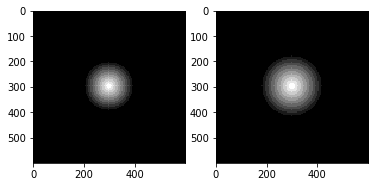

In [7]:
f1 = load_img_array(img_1_file_path)
f2 = load_img_array(img_2_file_path)
display_images([f1,f2])

In [8]:
class BackWardEstimator():
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ) -> None:
        img1 = Image.open(frame_1_file_name)
        img2 = Image.open(frame_2_file_name)
        self.f2 = np.asarray(img2)
        self.f1 = np.asarray(img1)
        self.window_size = 10
        self.block_size = 20
        self.flow_vectors = []
    
    def get_min_error_block(self,x :int,y:int) -> tuple:
        height, width = self.f2.shape[:2]
        left_x_bound = max(x-self.window_size,0)
        right_x_bound = min(x+self.window_size,height-self.block_size)
        left_y_bound = max(y-self.window_size,0)
        right_y_bound = min(y+self.window_size,width-self.block_size)
        block_1 = self.f2[x:x+self.block_size,y:y+self.block_size].astype(int)
        min_cost = float('inf')
        min_dist = float('inf')
        best_match = (0,0)
        for i in range(left_x_bound,right_x_bound):
            for j in range(left_y_bound,right_y_bound):
                block_2 = self.f1[i:i+self.block_size,j:j+self.block_size].astype(int)
                assert(block_1.shape == block_2.shape  or print(x,y,block_1.shape,block_2.shape,i,j,left_y_bound,right_y_bound))
                cost = np.mean(np.abs(block_1 - block_2))
                dist = (x-i)**2 + (y-j)**2
                if(cost <= min_cost and dist < min_dist):
                    min_cost = cost
                    best_match = (x,y,x-i,y-j)
                    min_dist = dist
    
        return best_match
    
    def back_ward_estimation(self) -> np.ndarray :
        height, width = self.f2.shape[:2]
        for x in tqdm(range(0,height-self.block_size+1,self.block_size)):
            for y in (range(0,width-self.block_size+1,self.block_size)):
                best_match = self.get_min_error_block(x,y)
                self.flow_vectors.append(best_match)
                
        img_to_display = np.copy(self.f2)
        for point in self.flow_vectors:
            x,y,dx,dy = point
            cv2.arrowedLine( img_to_display,(y,x), (int(dy+y),int(dx+x)), (0, 255, 0),1)
        
        print(f'Backward estimation by block wise method with {self.block_size} for block size and {self.window_size} for window size.')
        return img_to_display
    
    def __call__(self,block_size:int = 5) -> None:
        self.block_size = block_size
        return self.back_ward_estimation()

In [99]:
class BackWardEstimator():
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ,block_size:int = 25) -> None:
        img1 = Image.open(frame_1_file_name)
        img2 = Image.open(frame_2_file_name)
        self.f2 = np.asarray(img2)
        self.f1 = np.asarray(img1)
        self.window_size = 15
        self.block_size = block_size
        self.flow_vectors = []
    
    def get_min_error_block(self,x :int,y:int,show_block = False) -> tuple:
        height, width = self.f2.shape[:2]
        left_x_bound = max(x-self.block_size,0)
        right_x_bound = min(x+self.block_size,height-self.block_size)
        if(left_x_bound > right_x_bound):
            print('bad x')
        left_y_bound = max(y-self.block_size,0)
        right_y_bound = min(y+self.block_size,width-self.block_size)
        if(left_y_bound > right_y_bound):
            print('bad y')
        current_block = self.f2[x-self.block_size:x+self.block_size,y-self.block_size:y+self.block_size].astype(int)
        
        min_cost = float('inf')
        min_dist = float('inf')
        best_match = (0,0,0,0)
        if (show_block):
            print(f'{(left_x_bound,right_x_bound)=}')
            print(f'{(left_y_bound,right_y_bound)=}')
        best_block = None
        for i in range(left_x_bound,right_x_bound):
            for j in range(left_y_bound,right_y_bound):
                prev_block = self.f1[i-self.block_size:i+self.block_size,j-self.block_size:j+self.block_size].astype(int)
                if current_block.shape != prev_block.shape :
                    continue
                cost = np.mean(np.square(current_block - prev_block))
                if(cost < min_cost):
                    min_cost = cost
                    best_match = (x,y,i-x,j-y)
                    best_block = prev_block
                    
        if (show_block and best_block is not None):
            plt.imshow(current_block)
            plt.show()
            plt.imshow(best_block)
            plt.show()
        return best_match
    
    def back_ward_estimation(self) -> np.ndarray :
        height, width = self.f2.shape[:2]
        for x in tqdm(range(self.block_size,height-self.block_size+1,2*self.block_size)):
            for y in (range(self.block_size,width-self.block_size+1,2*self.block_size)):
                best_match = self.get_min_error_block(x,y)
                self.flow_vectors.append(best_match)
                
        img_to_display = np.copy(self.f2)
        for point in self.flow_vectors:
            x,y,dx,dy = point
            cv2.arrowedLine( img_to_display,(y,x), (int(dy+y),int(dx+x)), (255, 255, 0),1)
        
        print(f'Backward estimation by block wise method with {self.block_size} for block size and {self.window_size} for window size.')
        return img_to_display
    
    def display_backward_estimation(self)-> None:
        fig, ax = plt.subplots(figsize =(20, 10))
        img_to_display = self.back_ward_estimation()
        plt.imshow(img_to_display)
        
    def predict_f2(self,display=True) -> None:
        new_img = np.zeros_like(self.f2)
        for vec in self.flow_vectors:
            x,y,dx,dy = vec
            f1_x = x+dx
            f1_y = y+dy 
            block_size = self.block_size
            block_1 =  self.f1[f1_x-block_size:f1_x+block_size:,f1_y-block_size:f1_y+block_size]
            new_img[x-block_size:x+block_size,y-block_size:y+block_size] = block_1
        
        if(display):
            display_image(new_img)
        return new_img
    def get_mse(self):
        return np.mean(np.square(self.predict_f2(display=False).astype(int) - self.f2.astype(int)))
    def __call__(self,display:bool = True) -> None:
        if (display):
            return self.display_backward_estimation()
        return self.back_ward_estimation()

100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Backward estimation by block wise method with 25 for block size and 15 for window size.


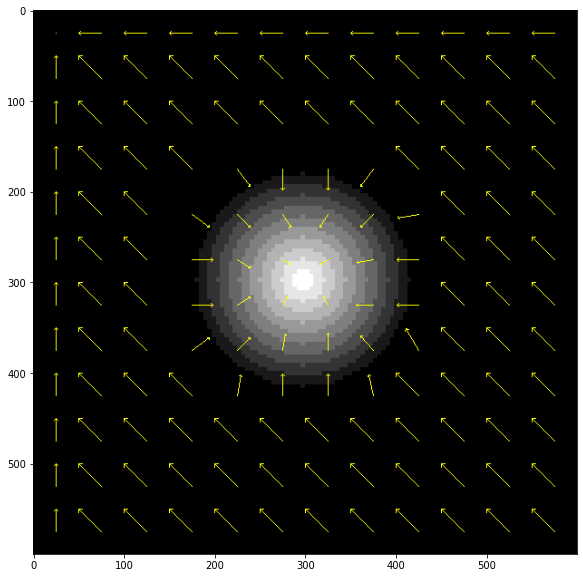

In [101]:
backward_estimator = BackWardEstimator(img_1_file_path,img_2_file_path)
backward_estimator()

## **Question (B)**
* Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ?
    
    On veut connaitre la frame de F2 à partir de F1, il convient donc de connaitre l'estimation de mouvement de F2 vers F1.

* Que se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)
    
    Nous aurions obtenu sûrement une estimation de mouvement incohérente, et du bruit dans l'image.

## **Question (C)**
Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?


Predicted F2


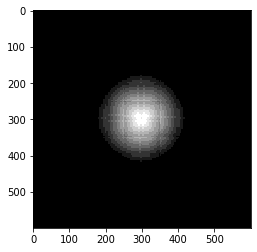

Real F2


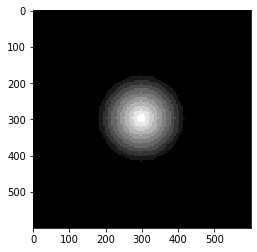

Mean squared error = 19.635358333333333


In [112]:
print('Predicted F2')
predicted_f2 = backward_estimator.predict_f2()
print('Real F2')
display_image(backward_estimator.f2)
mse = backward_estimator.get_mse()
print(f'Mean squared error = {mse}')

Difference between f2 and predicted f2 : 


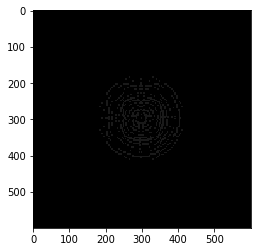

In [111]:
print('Difference between f2 and predicted f2 : ')
display_image(np.abs(backward_estimator.f2.astype(int) - predicted_f2.astype(int)))

**Observations:**
- Le rayon des cercles lumineux pour F2 et F2 predite sont similaires.
- Le centre de F2 prédite possède une trace légèrement quadrillée au centre.
- L'affichage de la différence entre F2 et F2 predite montre tout de même du bruit au niveau de la reconstitution du cercle.
- Le fond noir reste constant.
- La MSE ne semble pas témoigner d'une grande différence entre F2 et F2 predite.

## **Question (D)**
Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?


Il faut:
-  **champs de vecteur de l'estimation backward**

## **Question (E)**
Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

## **Question (F)**
Expliquez quelles données on peut coder avec perte pour garder une
qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus.

## **Question (G)**
Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.